In [7]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    os.environ['CUDA_VISIBLE_DEVICES'] = \
        os.environ['CUDA_VISIBLE_DEVICES'].split(',')[1]
    # '0,1,2,3,4,5'
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    
!nvidia-smi

/gpfs/u/scratch/PTFM/PTFMqngp/minoconda3_x86/envs/open-instruct/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0,4
4
Tue Nov 21 00:20:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   31C    P0    56W / 300W |   4960MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:16:00.0 Off |                    0 |
| 

In [ ]:
import os
import itertools
from rosemary import jpt_in_notebook
from llm.submit import submit_job, multiline_to_singleline, shell_scripts_template_slurm

log_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'

test_run = 1
test_run = bool(test_run)

# model_name = 'llama-7b'; encode_fn_type = 'sft'; md = 'llama7b'
# model_name = 'llama-7b+lora:r=256:a=256'; encode_fn_type = 'sft'; md = 'llama7b'
model_name = 'mistral-7b+lora:r=256:a=256'; encode_fn_type = 'sft'; md = 'mistral7b'
# model_name = 'all-mpnet-base-v2'; encode_fn_type = 'input'; md = 'mpnet'
# model_name = 'bge-large-en-v1.5'; encode_fn_type = 'input'; md = 'bge'

# nc_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
nc_list = [100, 500, 1000]
nc_list = [100, 200, 300, 400, 500, 600]

sort_by_list = [
    f'semdedup_cl=kmeansfaisscd_md={md}_dist=cd_emb={emb}_nc={nc}'
    for nc in nc_list
    for emb in ['text+embedding', 'grad+rp+loraB'] # 'grad+rp+loraB' 
]

# sort_by_list = [
#     'random_s=0', 'random_s=1', 'random_s=2',
#     'log_prob', 'logit_margin', 'el2n_agg=mean',
#     'grad_loraB_l2n', 'numtoks'
# ]
# sort_by_list += [
# #     'kmeansl2_emb=grad+rp+loraB_nc=300',
# #     'kmeansl2_emb=grad+rp+loraB_nc=1000',
#     'kmeansl2_emb=grad+rp+loraB_nc=3000',
# #     'kmeansl2_emb=text+embedding_nc=300',
#     'kmeansl2_emb=text+embedding_nc=1000',
# #     'kmeansl2_emb=text+embedding_nc=3000',
# ]
# sort_by_list = ['numtoks']

# sort_by_list += [
#     'dppmap_emb=grad+rp+loraB_k=Kcos', 
#     'dppmap_emb=text+embedding_k=Kcos', 
#     'dppmap_emb=grad+rp+loraB_k=Kcosp', 
#     'dppmap_emb=text+embedding_k=Kcosp',
#     'dppmap_emb=grad+rp+loraB_k=Kcos1np', 
#     'dppmap_emb=text+embedding_k=Kcos1np',
# ]
# dataset_list = ['lima']
# dataset_list = ['flan2022_1m']
# dataset_list = ['tulu_v1_mix']
# dataset_list = ['ultrachat']
dataset_list = ['ultrachat15']
# dataset_list = ['wizardlm']
# dataset_list = ['sharegpt']


# sort_by_list = [
#  'log_prob',
#  'el2n_agg=mean',
#  'el2n_agg=l2n',
#  'logit_margin',
# ]
# if 'lora' in model_name:
#     sort_by_list += ['grad_loraB_l2n']
# else:
#     sort_by_list += ['grad_all_l2n', 'grad_qkv_l2n', 'grad_mlp_l2n', 'grad_last_l2n',]
# sort_by_list = ['kmeansl2_emb=grad+rp+loraB_nc=30',
#                 'kmeansl2_emb=text+embedding_nc=30']
# dataset_list = ['lima']


# model_name = 'pythia-1b-deduped'
# model_name = 'pythia-1b-deduped+lora:r=256:a=256'
# dataset_list = ['cot', 'dolly', 'flan_v2', 'lima', 'oasst1']
# # sort_by_list = ['random_s=0', 
# #                 'log_prob', 'logit_margin', 'el2n_agg=mean', 'el2n_agg=l2n', 
# #                 'kmeansl2_nc=3000', 'kmeanscd_nc=3000',
# #                 'grad_loraB_l2n',
# #                 'grad_all_l2n', 'grad_qkv_l2n', 'grad_mlp_l2n', 'grad_last_l2n',
# #                ]
# sort_by_list = ['grad_loraB_l2n']

from note_pruning_analysis import data_inds_dir

options_list = itertools.product(dataset_list, sort_by_list)

print('test_run =',test_run)
cmds = []
for dataset, sort_by in options_list:
    save_dir = os.path.join(data_inds_dir, model_name, dataset)
    cmd = f"""
     python note_pruning.py \
        --dataset {dataset} \
        --sort_by {sort_by} \
        --model_name {model_name} \
        --encode_fn_type {encode_fn_type} \
        --save_dir {save_dir} \
    """.strip()
    cmd = multiline_to_singleline(cmd)
    shell_scripts = shell_scripts_template_slurm.format(
        conda_env='open-instruct',
        cwd=os.getcwd(),
        cmd=cmd,
        log_dir=log_dir,
        save_dir=save_dir)
    out = submit_job(
        shell_scripts, 
        job_name=f'prune.{dataset}.{sort_by}', 
        nodes=1,
        num_cpus=64, # 32
        cpu_mem=256, # 128
        num_gpus=1,
        gpu_type='v100',
        test_run=test_run,
        job_duration=6,
    )
    cmds.append(cmd)
    print(cmd)
        
print('#cmds: ', len(cmds))


In [ ]:
with open('note_pruning_run_cmds.sh', 'w') as f:
    s = 'set -e\nset -x\n'
    devices = os.environ['CUDA_VISIBLE_DEVICES']
    devices = 1
    s += '\n\n'.join([f"CUDA_VISIBLE_DEVICES={devices} "+x for x in cmds])
    f.write(s)

### Generate curriculum from pre-computed scores (via `note_pruning.py`)

In [ ]:
import itertools
from note_curriculum import (
    get_curriculum_scores,
    get_curriculum,
    generate_curriculum,
    generate_curriculum_forall_scoring_fn,
    scores_path_to_attrs,
    np_random_choice_maximize_noreplacement,
    plt_curriculum,
)
from note_pruning_analysis import assets_dir

# model_name = 'llama-7b'; dataset = 'tulu_v1_mix'; M = 150_000
# model_name = 'llama-7b'; dataset = 'sharegpt'; M = 150_000

## mistral+ultrachat
# model_name = 'mistral-7b'; dataset = 'ultrachat200k'; M = 50_000
# model_name = 'mistral-7b'; dataset = 'ultrachat15'; M = 100_000

## semdedup
# model_name = 'llama-7b'; dataset = 'wizardlm'; M = 100_000
# model_name = 'all-mpnet-base-v2'; dataset = 'wizardlm'; M = 100_000
# model_name = 'bge-large-en-v1.5'; dataset = 'wizardlm'; M = 100_000
# model_name = 'all-mpnet-base-v2'; dataset = 'ultrachat15'; M = 100_000
model_name = 'mistral-7b'; dataset = 'ultrachat15'; M = 100_000


pacing_fn_list = [
#     f'prune_size={M}_ep=1',
    f'prune_size={M}_ep=2',
#     f'prune_size={M}_ep=3',
#     f'singlestep_size={M}_startingfrac=0.1',
#     f'singlestep_size={M}_startingfrac=0.05',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.5',
]

output_list = generate_curriculum_forall_scoring_fn(
    model_name, dataset, pacing_fn_list, verbose=False)

In [ ]:
1

In [ ]:
import re
import numpy as np
from note_curriculum import get_curriculum_scores, generate_curriculum, plt_curriculum
import glob
import matplotlib.pyplot as plt

model_name = 'mistral-7b'; dataset = 'ultrachat'; M =  50_000
# model_name = 'llama-7b'; dataset = 'tulu_v1_mix'; M = 150_000


paths = glob.glob('curriculum/*/*/*/scores.pkl')
paths = [x for x in paths if 'llama' in x and 'tulu_v1_mix' in x and 'log_prob_neg' in x]
path = paths[0]

verbose = True
print(path)
pacing_fn = f'prune_size={M}_ep=3'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.1'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.2'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.3'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=2'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.2_inc=1.5'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5'

pacing_fn_list = [
    f'prune_size={M}_ep=3',
    f'singlestep_size={M}_startingfrac=0.05',
#     f'singlestep_size={M}_startingfrac=0.1',
#     f'singlestep_size={M}_startingfrac=0.2',
#     f'singlestep_size={M}_startingfrac=0.3',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=2',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=3',
    f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.5',
    f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=2',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=3',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.25'
]



nrows = len(pacing_fn_list)
fig, axs = plt.subplots(nrows, 3, figsize=(15,3*nrows), sharey=False, gridspec_kw={'width_ratios': [2,.5,.5]})

for i, pacing_fn in enumerate(pacing_fn_list):

    plt_kwargs = generate_curriculum(path, pacing_fn, verbose=True, save_output=False)
    output = plt_kwargs.pop('output')
    plt_kwargs.update({'fig': fig, 'axs': axs[i]})
    plt_curriculum(**plt_kwargs)

fig.tight_layout()



save_plt = 0
if save_plt:
    model_name, dataset, scoring_fn = output['model_name'], output['dataset'], output['scoring_fn']
    save_path = os.path.join(
        assets_dir, f'note_curriculum_{model_name}:{dataset}:{scoring_fn}.png')
    fig.savefig(save_path, bbox_inches='tight', dpi=100)



### main code

In [8]:
import os
import sys
import numpy as np
import time
import re
import random
import json
import pickle
from tqdm import tqdm 

import pyarrow
import torch
import transformers
import pandas as pd

from note_pruning import (
    save_to_pickle,
    save_sorted_inds,
    sort_kmeans_dist_to_cluster_centers,
    sort_dpp_map,
    save_prune_results,
    sort_dpp_map_memefficient,
)
from note_pruning_analysis import get_lm_output

In [9]:
test_run = False
dataset = 'tulu_v1_human_mix'
dataset = 'tulu_v2_human_mix'
dataset = 'flan_v2'
dataset = 'lima'
dataset = 'flan2022_1m'
dataset = 'tulu_v1_mix'
dataset = 'lima'
dataset = 'ultrachat200k'
dataset = 'ultrachat15'
dataset = 'wizardlm'

# sort_by = 'random_s=0'
# sort_by = 'kmeansl2_nc=3000'
# sort_by = 'kmeanscd_nc=3000'
# sort_by = 'log_prob'
# sort_by = 'dppmap_k=Kcos'
# sort_by = 'dppmap_k=Kcos1np'
# sort_by = 'el2n'
# sort_by = 'grad_norm'
# sort_by = 'kmeansl2_emb=grad+rp+loraB_nc=3000'
# sort_by = 'kmeansl2_emb=text+embedding_nc=3000'
sort_by = 'dppmap_emb=text+embedding_k=Kcos'
# sort_by = 'logit_margin'
# rhov1: mistral-7b base-tuned(ultrachat200k_beforesplitlongconv)
# sort_by = 'rhov1'
# sort_by = 'numtoks'

# used for generating model output.
# model_name = 'llama-7b'; encode_fn_type = 'sft'
# model_name = 'llama-7b_ft=hmv1'; encode_fn_type = 'sft'
# model_name = 'llama-7b+lora:r=256:a=256'; encode_fn_type = 'sft'
# model_name = 'mistral-7b+lora:r=256:a=256'; encode_fn_type = 'sft'
model_name = 'all-mpnet-base-v2'; encode_fn_type = 'input'
# model_name = 'bge-large-en-v1.5'; encode_fn_type = 'input'

# model_name = 'mistral-7b+lora:r=256:a=256__rho__mistral-7b-ultrachat200k-v1+lora:r=256:a=256'


save_dir = f"data_inds/"
save_dir = os.path.join(save_dir, '' if encode_fn_type=='sft' else encode_fn_type, model_name, dataset)
os.makedirs(save_dir, exist_ok=True) 

print(dataset, model_name, sort_by)
print(save_dir)

wizardlm all-mpnet-base-v2 dppmap_emb=text+embedding_k=Kcos
data_inds/input/all-mpnet-base-v2/wizardlm


In [4]:
d = get_lm_output(dataset, model_name, encode_fn_type=encode_fn_type, return_text_embedding=True)
if test_run:
    d = {k: v[:1000] for k, v in d.items()}
    
# some entries are nan, impute with mean value.
N = d['text_embedding'].shape[0]
print(N)

143000


In [ ]:
sort_by = 'dppmap_emb=text+embedding_k=Kcos'
# 'semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text+embedding_nc=200',

sort_by = 'dppmap_cl=kmeansfaisscd_md=mpnet_emb=text+embedding_nc=200'


kwd = parse_kv_from_string(sort_by)


match = re.search(r'k=(\w+)', sort_by)
kernel_type = match.group(1) if match else None
match = re.search(r'emb=([^_]+)', sort_by)
embed_type = re.sub(r'[+]', '_', match.group(1)) if match else 'text_embedding'
if embed_type not in set(d.keys()).intersection(set(['text_embedding', 'grad_rp_loraB'])):
    raise ValueError(f'Invalid embed_type = {embed_type}')
md = re.search(r'md=([^_]+)', sort_by).group(1)
if (md == 'mpnet' and model_name != 'all-mpnet-base-v2') or \
   (md == 'bge' and model_name != 'bge-large-en-v1.5') or \
   (md == 'llama7b' and not model_name.lower().startswith('llama-7b')) or \
   (md == 'mistral7b' and not model_name.lower().startswith('mistral-7b')):
    raise ValueError(f'md={md} does not match with model_name={model_name}')
print(kernel_type, embed_type)


In [ ]:

match = re.search(r'k=(\w+)', sort_by)
kernel_type = match.group(1) if match else None
match = re.search(r'emb=([^_]+)', sort_by)
embed_type = re.sub(r'[+]', '_', match.group(1)) if match else 'text_embedding'
if embed_type not in set(d.keys()).intersection(set(['text_embedding', 'grad_rp_loraB'])):
    raise ValueError(f'Invalid embed_type = {embed_type}')
    md = re.search(r'md=([^_]+)', sort_by).group(1)
    if (md == 'mpnet' and model_name != 'all-mpnet-base-v2') or \
       (md == 'bge' and model_name != 'bge-large-en-v1.5') or \
       (md == 'llama7b' and not model_name.lower().startswith('llama-7b')) or \
       (md == 'mistral7b' and not model_name.lower().startswith('mistral-7b')):
        raise ValueError(f'md={md} does not match with model_name={model_name}')
emb = d[embed_type]
log_prob = d['log_prob']
# inds = sort_dpp_map_memefficient(emb, log_prob, kernel_type=kernel_type, torch_compile=False)


In [10]:

sort_by = 'dppmap_cl=kmeansfaisscd_md=mpnet_emb=text+embedding_nc=200'
sort_by = 'dppmap_k=vmf_gamma=1.0_kmd=mpnet_kemb=text+embedding'


from rosemary import parse_kv_from_string
kvs = parse_kv_from_string(sort_by)

## wpq: note since dppmap potentially rely on output of >1 model,
#  set `model_name` to whatever model that generates the quality score.
#  e.g., model_name=llama-7b, md=mpnet since use its embedding on instructions, 
#      and q=log_prob uses log probability from llama-7b
# 

if kvs['k'] == 'vmf':
    kernel_kwargs = {'gamma': kvs['gamma']}
elif kvs['k'] == 'rbf':
    kernel_kwargs = {'sigma': kvs['sigma']}
else:
    kernel_kwargs = {}
kwargs = {
    'dataset': dataset,
    'kernel_type': kvs['k'],
    'kernel_embed_model': kvs['kmd'],
    'kernel_embed_type': re.sub(r'[+]', '_', kvs['kemb']) if 'kemb' in kvs else None,
    'kernel_kwargs': kernel_kwargs,
    'quality_score_type': 'log_prob', #kvs.get('q', None),
    'quality_score_embed_model': kvs.get('qmd', None),
}


dataset = dataset
kernel_type = kvs['k']
kernel_embed_model = kvs['kmd']
kernel_embed_type = re.sub(r'[+]', '_', kvs['kemb'])
quality_score_type = 'log_prob' #kvs.get('q', None)
quality_score_embed_model = 'llama7b' # kvs.get('qmd', None)
kernel_kwargs = kwargs['kernel_kwargs']


#     inds = sort_dpp_map_memefficient(emb, log_prob, kernel_type=kernel_type, torch_compile=False)

import sys
sys.path.insert(0, "/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/fast-map-dpp")
from dpp import dpp_lazy

from functools import partial
from note_pruning_dpp import torch_vmf_kernel, torch_rbf_kernel


def get_full_model_name(md):
    if md == 'mpnet':
        model_name = 'all-mpnet-base-v2'
    elif md == 'bge':
        model_name = 'bge-large-en-v1.5'
    elif md == 'llama7b':
        model_name = 'llama-7b+lora:r=256:a=256'
    elif md == 'mistral7b':
        model_name = 'mistral-7b+lora:r=256:a=256'
    else:
        raise ValueError(f'Dont know full name for model_name={md}')
    return model_name

if kernel_type not in ['ip', 'vmf', 'rbf']:
    raise ValueError(f'kernel_type={kernel_type} not supported.')
if kernel_embed_model not in ['mpnet', 'bge', 'llama7b', 'mistral7b']:
    raise ValueError(f'kernel_embed_model={kernel_embed_model} not supported.')
if kernel_embed_type not in ['text_embedding', 'grad_rp_loraB']:
    raise ValueError(f'kernel_embed_type={kernel_embed_type} not supported.')
    
dk = get_lm_output(
    dataset, 
    get_full_model_name(kernel_embed_model),
    encode_fn_type='input' if kernel_embed_model in ['mpnet', 'bge'] else 'sft', 
    return_text_embedding=True)
X = dk[kernel_embed_type]
if any(x in kernel_embed_model for x in ['mpnet', 'bge']):
    X = X / np.maximum(np.linalg.norm(X, axis=-1, keepdims=True), 1e-8) # possibly divide by zero.


if quality_score_type is None:
    class IdentityQuality:
        def __getitem__(self, i):
            return 1
    Q = IdentityQuality()
else:
    dq = get_lm_output(
        dataset, 
        get_full_model_name(quality_score_embed_model),
        encode_fn_type='input' if quality_score_embed_model in ['mpnet', 'bge'] else 'sft', 
        return_text_embedding=True)
    Q = dq[quality_score_type]
    Q = Q.reshape(-1, 1)

if not X.shape[0] == Q.shape[0]:
    raise ValueError(f'X ({X.shape}) and Q (Q.shape) does not match')

if kernel_type == 'vmf':
    kernel_fn = partial(torch_vmf_kernel, **kernel_kwargs)
elif kernel_type == 'rbf':
    kernel_fn = partial(torch_rbf_kernel, **kernel_kwargs)
else:
    raise ValueError(f'kernel_type={kernel_type} not supported.')
    
    




N = X.shape[0]
kernel_type

    

'vmf'

In [11]:
import math
# (1.5*10**6 * 50_000 * 4) / 1024**3

def dpp_np(kernel_matrix, max_length, epsilon=1E-10):
    """
    Our proposed fast implementation of the greedy algorithm
    :param kernel_matrix: 2-d array
    :param max_length: positive int
    :param epsilon: small positive scalar
    :return: list
    """
    item_size = kernel_matrix.shape[0]
    cis = np.zeros((max_length, item_size))
    di2s = np.copy(np.diag(kernel_matrix))
    selected_items = list()
    selected_item = np.argmax(di2s)
    selected_items.append(selected_item)
    while len(selected_items) < max_length:
        if len(selected_items)%(max_length//10)==0:
            print('fast_map_dpp iterations = ',len(selected_items))
        k = len(selected_items) - 1
        ci_optimal = cis[:k, selected_item]
        di_optimal = math.sqrt(di2s[selected_item])
        elements = kernel_matrix[selected_item, :]
#         print(elements.shape, ci_optimal.shape, cis[:k, :].shape, di_optimal)
#         print(ci_optimal, cis[:k,:], np.dot(ci_optimal, cis[:k,:]))
#         print((elements - np.dot(ci_optimal, cis[:k, :])))
        if k == 0:
            eis = elements
        else:
            print(k, ci_optimal.shape, cis[:k, :].shape)
            eis = (elements - np.dot(ci_optimal, cis[:k, :])) / di_optimal
#         print(eis)
        cis[k, :] = eis
        di2s -= np.square(eis)
        di2s[selected_item] = -np.inf
        selected_item = np.argmax(di2s)
        if di2s[selected_item] < epsilon:
            print(di2s[selected_item])
            break
        selected_items.append(selected_item)
    return selected_items



def dppmap(Ki, Kdiag, M, epsilon=1e-10, verbose=True):
    """dpp map inference 
            - https://arxiv.org/pdf/1709.05135.pdf
    """
    N = K.shape[0]
    # print(f'Memory for cis: {M*N*4/(1024**3)} GB')
    # (M, N)
    cis = torch.zeros((M, N), dtype=torch.float32)
    # (N,)
    di2s = torch.diag(K)
    # grows to at most length M
    inds = []
    j = torch.argmax(di2s).item()
    inds.append(j)
    while len(inds) < M:
        if verbose:
            if len(inds) % (M // 10) == 0:
                print('fast_map_dpp iterations = ', len(inds))
        k = len(inds) - 1
        # (k,)
        ci_optimal = cis[:k, j]
        di_optimal = torch.sqrt(di2s[j])
        Kj = K[j, :]
        # (N,) - (k,)@(k,N) -> (N,)
        eis = (Kj - ci_optimal@cis[:k, :]) / di_optimal
        # update to k are updated.
        cis[k, :] = eis
        di2s -= torch.square(eis)
        di2s[j] = -float('inf')
        j = torch.argmax(di2s).item()

        if di2s[j] < epsilon:
            print(f'Stop on dᵢ^2 = {di2s[j]}')
            break
        inds.append(j)

    return inds


XX = X[:100]
XX = torch.from_numpy(XX)

kernel_fn = partial(torch_vmf_kernel, **kernel_kwargs)
print(kernel_fn)


K = kernel_fn(XX, XX)
k = 10

device = 'cuda'
inds = dppmap(K, k)
print(inds)


# inds_np = dpp_np(K.numpy(), k)
# print(inds_np)


functools.partial(<function torch_vmf_kernel at 0x7f5751396b90>, gamma=1.0)


TypeError: dppmap() missing 1 required positional argument: 'M'

In [13]:
i = 0
kernel_fn(XX[i], XX)

tensor([1.0000, 0.6012, 0.6346, 0.7396, 0.6801, 0.6672, 0.6004, 0.6556, 0.7009,
        0.7131, 0.6304, 0.6623, 0.6418, 0.6371, 0.7030, 0.6056, 0.6052, 0.6030,
        0.6130, 0.6558, 0.6738, 0.6401, 0.6797, 0.6598, 0.6209, 0.6926, 0.6393,
        0.6475, 0.6048, 0.6312, 0.7039, 0.6910, 0.6626, 0.6068, 0.6211, 0.6762,
        0.6631, 0.6091, 0.6494, 0.6313, 0.6523, 0.6010, 0.6503, 0.6498, 0.6331,
        0.6711, 0.6420, 0.6562, 0.6808, 0.6466, 0.6131, 0.6687, 0.6065, 0.6397,
        0.7244, 0.6231, 0.6423, 0.6724, 0.6509, 0.6427, 0.6828, 0.6403, 0.6659,
        0.6556, 0.6364, 0.6081, 0.6259, 0.6425, 0.6845, 0.6386, 0.6564, 0.6480,
        0.6175, 0.6821, 0.6352, 0.6627, 0.6342, 0.6620, 0.6126, 0.6297, 0.6847,
        0.6368, 0.6352, 0.6113, 0.6370, 0.6339, 0.7008, 0.6400, 0.6300, 0.6418,
        0.6189, 0.6408, 0.6256, 0.6046, 0.6131, 0.6118, 0.6885, 0.6277, 0.6333,
        0.6364])

/tmp/ipykernel_15256/1656774835.py:7: RuntimeWarning: divide by zero encountered in divide
  ys = xs/(2*(1-xs))


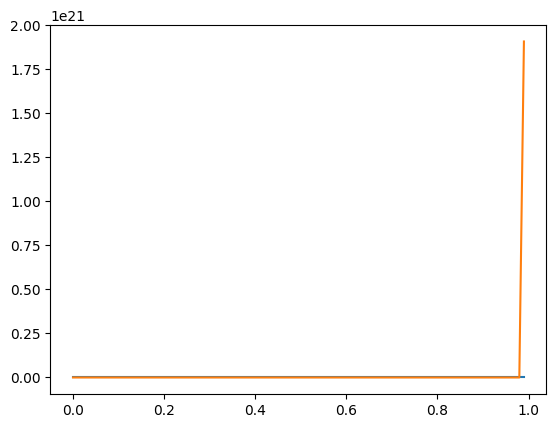

In [19]:
# def Ki(i):
#     """Returns i-th row of kernel matrix K"""
    

import matplotlib.pyplot as plt
xs = np.linspace(0, 1, 100)
ys = xs/(2*(1-xs))
plt.plot(xs,ys)
ys = np.exp(ys)
plt.plot(xs,ys)

In [81]:
# Cost of computing (given feature_dim=d, size of kernel=N)
# - K[i,:]: O(dN)
# - ci_optimal@cis[:k, :]: O(kN) for large k is very costly.

print(f'Memory for cis: {50_000*200_000*4/(1024**3)} GB')

Memory for cis: 37.25290298461914 GB


In [41]:

X = torch.rand(10,3)
X = X / np.maximum(np.linalg.norm(X, axis=-1, keepdims=True), 1e-8)
kernel_fn(X, X)

tensor([[1.0000, 0.9456, 0.9343, 0.9641, 0.9337, 0.9126, 0.9139, 0.8069, 0.9716,
         0.9713],
        [0.9456, 1.0000, 0.9990, 0.9928, 0.8873, 0.8680, 0.9016, 0.9373, 0.8563,
         0.9262],
        [0.9343, 0.9990, 1.0000, 0.9868, 0.8864, 0.8686, 0.8861, 0.9426, 0.8424,
         0.9104],
        [0.9641, 0.9928, 0.9868, 1.0000, 0.8743, 0.8510, 0.9418, 0.9215, 0.8817,
         0.9624],
        [0.9337, 0.8873, 0.8864, 0.8743, 1.0000, 0.9982, 0.7503, 0.7303, 0.9349,
         0.8365],
        [0.9126, 0.8680, 0.8686, 0.8510, 0.9982, 1.0000, 0.7217, 0.7130, 0.9193,
         0.8090],
        [0.9139, 0.9016, 0.8861, 0.9418, 0.7503, 0.7217, 1.0000, 0.8617, 0.8498,
         0.9809],
        [0.8069, 0.9373, 0.9426, 0.9215, 0.7303, 0.7130, 0.8617, 1.0000, 0.6919,
         0.8309],
        [0.9716, 0.8563, 0.8424, 0.8817, 0.9349, 0.9193, 0.8498, 0.6919, 1.0000,
         0.9270],
        [0.9713, 0.9262, 0.9104, 0.9624, 0.8365, 0.8090, 0.9809, 0.8309, 0.9270,
         1.0000]])

In [4]:
import torch
import math

n = 5_000
a, b = torch.rand(n), torch.rand(n, 1_500_000)

((a.numel() + b.numel())*4 / (1024**3))


5.5879391729831696

NameError: name 'chunk_size' is not defined

In [2]:

# 
import time
import torch
import math

def matmul_mem_efficient(a, b, device='cuda', split_dim=1, gpu_mem_budget=.1):
    """assume `b` is more memory intensive
        put `a` into gpu memory by default.
        and put chunks of `b` into memory. """
    num_chunks = math.ceil(((a.numel() + b.numel())*4 / (1024**3)) / gpu_mem_budget)
    split_size = math.ceil(b.shape[split_dim] / num_chunks)
    c = []
    a = a.to(device)
    b_split = torch.split(b, split_size, dim=split_dim)
    for bi in b_split:
        bi = bi.to(device,  non_blocking=True)
        ci = a@bi
        c.append(ci.to('cpu'))
    c = torch.hstack(c)
    return c


def matmul_mem_efficient2(a, b, device='cuda', split_dim=1, gpu_mem_budget=.1):
    """assume `b` is more memory intensive
        put `a` into gpu memory by default.
        and put chunks of `b` into memory. """
    num_chunks = math.ceil(((a.numel() + b.numel())*4 / (1024**3)) / gpu_mem_budget)
    split_size = math.ceil(b.shape[split_dim] / num_chunks)
    c = []
    a = a.to(device)
    b_split = torch.split(b, split_size, dim=split_dim)
    for bi in b_split:
        bi = bi.to(device,  non_blocking=True)
        ci = a@bi
        c.append(ci.to('cpu'))
    c = torch.hstack(c)
    return c


a, b = torch.rand(1000), torch.rand(1000, 1_500_000)


t0 = time.time()
matmul_mem_efficient(a, b, gpu_mem_budget=5)
print(time.time()-t0)

t0 = time.time()
a@b
print(time.time()-t0)

1.48 s ± 118 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.27 s ± 78.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
79.2 ms ± 699 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [3]:
%timeit matmul_mem_efficient(a, b, gpu_mem_budget=5)


1.22 s ± 13.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [146]:
# b.shape[0] / (num_chunks+1)
# b.shape[0] / (num_chunks)

[x.shape for x in b_split]




[torch.Size([100, 250000]),
 torch.Size([100, 250000]),
 torch.Size([100, 250000]),
 torch.Size([100, 250000]),
 torch.Size([100, 250000]),
 torch.Size([100, 250000])]

In [35]:

logP = torch.from_numpy(logP).to('cuda')
P = logP.exp()

N = P.shape[0]

if torch_compile:
    X = X / np.linalg.norm(X, axis=-1, ord=2, keepdims=True)
else:
    X = torch.from_numpy(X).to('cuda')
    X = torch.nn.functional.normalize(X, dim=-1)

jitter = 1e-3

def kernel_matrix_ith_row(i):
    """Returns i-th row of kernel matrix `K`"""
    if kernel_type == 'Kcos':
        Ki = X[i]@X.T
    elif kernel_type == 'Kcosp':
        Ki = P[i]*X[i]@X.T*P.reshape(1,N)
    elif kernel_type == 'Kcos1np':
        Ki = (1-P[i])*X[i]@X.T*(1-P.reshape(1,N))
    else:
        raise ValueError(f'kernel_type={kernel_type} not supported')
    Ki = Ki.squeeze()
    Ki[i] += jitter
    if torch_compile:
        return Ki
    else:
        return Ki.to('cpu').numpy()

def kernel_matrix_diag(): 
    if kernel_type == 'Kcos':
        Kdiag = (X*X).sum(-1)
    elif kernel_type == 'Kcosp':
        Kdiag = (X*X).sum(-1) * (P*P)
    elif kernel_type == 'Kcos1np':
        Kdiag = (X*X).sum(-1) * ((1-P)*(1-P))
    else:
        raise ValueError(f'kernel_type={kernel_type} not supported')
    Kdiag = Kdiag.squeeze()
    Kdiag += jitter
    if torch_compile:
        return Kdiag
    else:
        return Kdiag.to('cpu').numpy()

max_length = min(50000, int(.3*N))
if torch_compile:
    dpp_lazy = torch.compile(dpp_lazy)
    kernel_matrix_ith_row = torch.compile(kernel_matrix_ith_row)
    kernel_matrix_diag = torch.compile(kernel_matrix_diag)
inds = dpp_lazy(N, kernel_matrix_ith_row, kernel_matrix_diag, max_length, jitter)
if len(inds) != N:
    print(f'dpp map len(indices)={len(inds)} != {N} = N')
    
    


True

Calling note_pruning_clustering.main with kwargs={
    "model_name": "all-mpnet-base-v2",
    "dataset": "wizardlm",
    "encode_fn_type": "input",
    "clustering_fn": "cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200",
    "embed_type": "text_embedding",
    "normalize_embeddings": true,
    "first_N": null,
    "save_dir": "clustering/input/all-mpnet-base-v2/wizardlm/cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200"
}
Sampling a subset of 51200 / 143000 for training
Clustering 51200 points in 768D to 200 clusters, redo 1 times, 30 iterations
  Preprocessing in 0.22 s
  Iteration 29 (13.94 s, search 11.78 s): objective=28569.9 imbalance=1.112 nsplit=0       
Apply SemDeDup to discard duplicates.
brute force compute scores for semdedup. max step length = 911


In [ ]:
## the copy in `note_pruning.py` is most up to date

pkl_extra = {}
inds = None

# sort_by = 'semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200'

t0 = time.time()
if any(sort_by.startswith(x) for x in [
        'log_prob', 
        'el2n',  # el2n_agg={l2n|mean}
        'logit_margin', 
        'grad',  # grad_{loraB|qkv|all|last}_l2n
    ]):
    if sort_by not in d:
        print(f'sort_by={sort_by} not in model output: ({dataset}, {model_name})')
    S = np.nan_to_num(d[sort_by], nan=np.nanmean(d[sort_by])).squeeze()
elif sort_by.startswith('random'):
    match = re.search(r's=(\d+)', sort_by)
    seed = int(match.group(1))
    np.random.seed(seed)
    S = np.random.rand(N)
    assert(S.shape == np.unique(S).shape)
if sort_by.startswith('kmeans'):
    dist_fn = 'l2' if sort_by.startswith('kmeansl2') else 'cd'
    match = re.search(r'nc=(\d+)', sort_by)
    n_clusters = int(match.group(1)) if match else None
    match = re.search(r'emb=([^_]+)', sort_by)
    embed_type = re.sub(r'[+]', '_', match.group(1)) if match else 'text_embedding'
    if embed_type not in set(d.keys()).intersection(set(['text_embedding', 'grad_rp_loraB'])):
        raise ValueError(f'Invalid embed_type = {embed_type}')
    emb = d[embed_type]
    print(f'Running kmeans(n_clusters={n_clusters}) {{ {embed_type} }} to compute {"euclidean" if dist_fn == "l2" else "cosine"} distance to cluster centers.')
    S, kms = sort_kmeans_dist_to_cluster_centers(emb, n_clusters, dist_fn=dist_fn)
    pkl_extra['kmeans'] = kms
elif sort_by.startswith('semdedup'):
    import note_pruning_clustering
    from rosemary import parse_kv_from_string
    kvs = parse_kv_from_string(sort_by)
    md = kvs['md']
    if (md == 'mpnet' and model_name != 'all-mpnet-base-v2') or \
       (md == 'bge' and model_name != 'bge-large-en-v1.5') or \
       (md == 'llama7b' and not model_name.lower().startswith('llama-7b')) or \
       (md == 'mistral7b' and not model_name.lower().startswith('mistral-7b')):
        raise ValueError(f'md={md} does not match with model_name={model_name}')
    clustering_fn = create_string_from_kv(
        {k: v for k, v in kvs.items() if k in ['cl', 'nc', 'bsz', 'ms', 'emb']})
    dist = kvs['dist']
    assert(dist in ['cd', 'l2'])
    embed_type = re.sub(r'[+]', '_', kvs['emb'])
    if embed_type not in set(d.keys()).intersection(set(['text_embedding', 'grad_rp_loraB'])):
        raise ValueError(f'Invalid embed_type = {embed_type}')
    save_dir_clustering = os.path.join('clustering', encode_fn_type, model_name, dataset, clustering_fn)
    os.makedirs(save_dir_clustering, exist_ok=True)
    # normalize embeddings to unit norm if the model that generated the embeddings does the 
    # same, e.g., mpnet, bge, or if using spherical kmeans clustering.
    if any(x in model_name for x in ['mpnet', 'bge']) or 'kmeansfaisscd' in clustering_fn:
        normalize_embeddings = True
    else:
        normalize_embeddings = False
    kwargs = {
        'model_name': model_name,
        'dataset': dataset,
        'encode_fn_type': encode_fn_type,
        'clustering_fn': clustering_fn,
        'embed_type': embed_type,
        'normalize_embeddings': normalize_embeddings,
        'first_N': None,
        'save_dir': save_dir_clustering,
    }
    print(f'Calling note_pruning_clustering.main with kwargs={json.dumps(kwargs, indent=4)}')
    X, Y, C = note_pruning_clustering.main(**kwargs)
    print('Apply SemDeDup to discard duplicates.')
    S = note_pruning_clustering.semdedup(X, Y, dist=dist, device='cuda')
elif sort_by.startswith('dpp'):
    match = re.search(r'k=(\w+)', sort_by)
    kernel_type = match.group(1) if match else None
    match = re.search(r'emb=([^_]+)', sort_by)
    embed_type = re.sub(r'[+]', '_', match.group(1)) if match else 'text_embedding'
    if embed_type not in set(d.keys()).intersection(set(['text_embedding', 'grad_rp_loraB'])):
        raise ValueError(f'Invalid embed_type = {embed_type}')
    emb = d[embed_type]
    log_prob = d['log_prob']
    inds = sort_dpp_map_memefficient(emb, log_prob, kernel_type=kernel_type, torch_compile=False)
elif sort_by.startswith('rho'):
    if sort_by == 'rhov1':
        model_names = ['mistral-7b+lora:r=256:a=256',
                       'mistral-7b-ultrachat200k-v1+lora:r=256:a=256']
        assert(model_name == model_names[0])
    else:
        raise ValueError(f'sort_by={sort_by} not implemented.')
    assert(len(model_names) == 2)
    ds = []
    for x in model_names:
        ds.append(get_lm_output(dataset, x, return_text_embedding=False, fill_nan=False))
    ks = [set(d.keys()) for d in ds]
    ks = ks[0] & ks[1]
    for k in ks:
        S0 = ds[0][k]
        S1 = ds[1][k]
        # handle nan entries properly.
        nan_mask = np.logical_or(np.isnan(S0), np.isnan(S1))
        S = np.subtract(S0, S1)
        S[nan_mask] = np.nan
        S = S.squeeze()
        save_prune_results(save_dir, None, S, {}, f'{sort_by}_{k}', model_name, dataset)
elif sort_by.startswith('numtoks'):
    from transformers import AutoTokenizer
    from note_pruning_analysis import get_dataset_token_lengths
    if 'llama' in model_name or 'mistral' in model_name:
        tokenizer = AutoTokenizer.from_pretrained(
            '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/results/baselines/huggyllama/llama-7b',
            use_fast=False, # use_fast sometimes cause error.
        )
    else:
        raise ValueError('Need to supply appropriate tokenizer to count token lengths,')
    d = get_dataset_token_lengths(dataset, tokenizer)

    d['total_len'] = d['input_len'] + d['output_len']
    for k in ['input', 'output', 'total']:
        S = d[f'{k}_len']
        save_prune_results(save_dir, None, S, {}, f'{sort_by}_{k}', model_name, dataset)

        
t1 = time.time()
print(f'Rank datapoints with {sort_by} took {t1-t0:.2f} seconds.')

# from note_pruning import save_prune_results
if not any(sort_by.startswith(x) for x in ['rho', 'numtoks']):
    save_prune_results(save_dir, inds, S, pkl_extra, sort_by, model_name, dataset)

In [ ]:
k = 'log_prob'
t = 100
S0 = ds[0][k].squeeze()[::t]
S1 = ds[1][k].squeeze()[::t]
# log prob neg
S0, S1 = -S0, -S1
# S = S0-S1

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(20, 3))
xs = np.arange(len(S0))
inds_sorted = np.argsort(S0)
ax.plot(xs, S0[inds_sorted], label='S_base')
ax.plot(xs, S1[inds_sorted], label='S_train')
ax.plot(xs, S[inds_sorted], label='S_base-S_train')
ax.legend()
ax.set_title(f'{model_name}  {dataset}  sort_by={sort_by}', fontsize=20)


fig, ax = plt.subplots(1,1,figsize=(20, 3))
xs = np.arange(len(S0))
inds_sorted = np.argsort(S1)
ax.plot(xs, S0[inds_sorted], label='S_base')
ax.plot(xs, S1[inds_sorted], label='S_train')
ax.plot(xs, S[inds_sorted], label='S_base-S_train')
ax.legend()


fig, ax = plt.subplots(1,1,figsize=(20, 3))
xs = np.arange(len(S0))
inds_sorted = np.argsort(S)
ax.plot(xs, S0[inds_sorted], label='S_base')
ax.plot(xs, S1[inds_sorted], label='S_train')
ax.plot(xs, S[inds_sorted], label='S_base-S_train')
ax.legend()